In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn

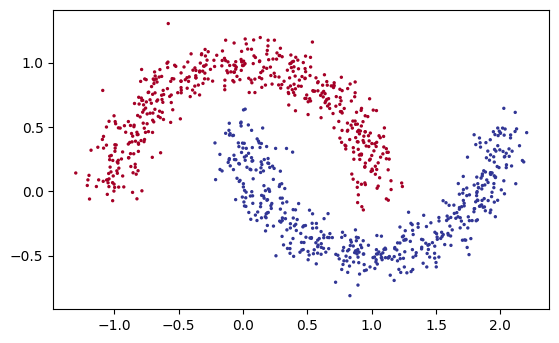

In [46]:
NUM_SAMPLES = 1000
NOISE = 0.1
RANDOM_STATE = 1

X, y = make_moons(n_samples=NUM_SAMPLES, noise=NOISE, random_state=RANDOM_STATE)
fig, ax = plt.subplots(1)

ax.scatter(x=X[:, 0], y=X[:, 1], c=y, s=2, cmap=plt.cm.RdYlBu)
ax.set_aspect("equal", "box")
plt.show()

In [47]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
class MoonModel(nn.Module):
    def __init__(self, n1, n2):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=n1)
        self.layer_2 = nn.Linear(in_features=n1, out_features=n2)
        self.layer_3 = nn.Linear(in_features=n2, out_features=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        return self.layer_3(self.tanh(self.layer_2(self.tanh(self.layer_1(x)))))

In [49]:
def accuracy_fn(y_true, y_pred):
    correct = (torch.eq(y_true, y_pred).sum().item())
    acc = (correct / len(y_pred)) * 100
    return acc

In [50]:
model = MoonModel(10, 6).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
epochs = 200

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

In [51]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

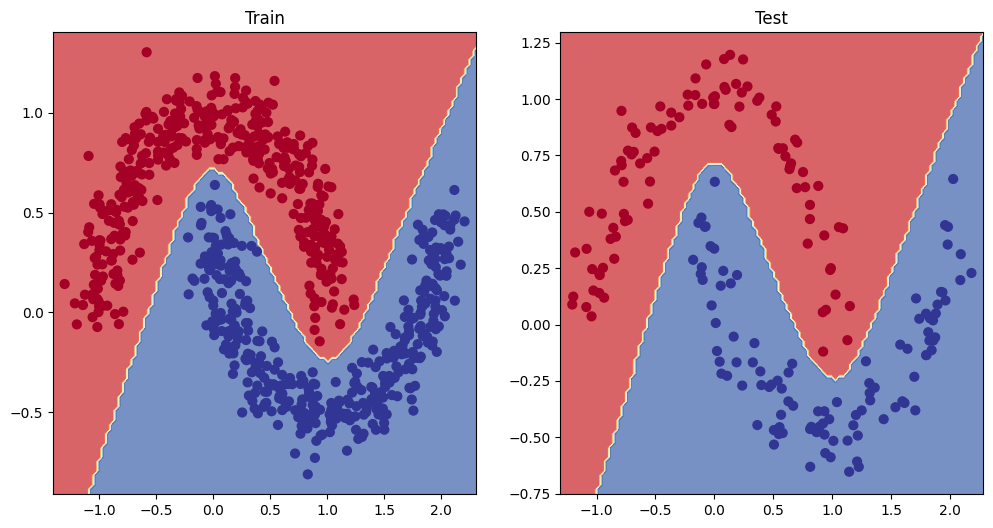

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)